In [135]:
# Libraries

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
)
from statsmodels.formula.api import ols

In [2]:
# Load GeoJSON file

geo_data = gpd.read_file("files/ASU expansion prediction layer.geojson")

locations = pd.read_csv("files/location.csv")

pay = pd.read_excel("files/pay.xlsx")

PaymentsNumber = pd.read_csv("files/PaymentsNumber.csv")

/tmp/ipykernel_13053/4153638662.py:9: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  PaymentsNumber = pd.read_csv("files/PaymentsNumber.csv")


In [3]:
status = pd.read_csv("files/statuses.csv")

status.head()

,accountRef,customerId,status
0,38649948,94769,Current
1,22734253,94963,Current
2,29584649,95011,Current
3,35740195,95104,Current
4,32226994,95118,Arrears


In [4]:
geo_data.head()

,VALUE,geometry
0,0.704912,"POLYGON ((-6.3 10.686, -6.25 10.686, -6.25 10...."
1,0.658177,"POLYGON ((-6.65 10.636, -6.6 10.636, -6.6 10.6..."
2,0.424820,"POLYGON ((-6.4 10.636, -6.35 10.636, -6.35 10...."
3,0.708788,"POLYGON ((-6.35 10.636, -6.3 10.636, -6.3 10.6..."
4,0.708788,"POLYGON ((-6.3 10.636, -6.25 10.636, -6.25 10...."


In [5]:
locations.head()

,customer_id,longitude,latitude
0,130193,40.459112,-2.412965
1,129883,39.383565,-4.578562
2,88403,NaN,NaN
3,101188,34.191259,0.327704
4,66809,35.198002,0.341063


In [7]:
pay.head()

,paymentId,paymentType,instalmentScheduleId,amtPaid,installmentType,paymentSequence,expectedAmount,expectedDate,id,accountRef,amount,timestampMade
0,456727,0,842370,4599,installment,1,4599,2023-06-15,456727,X2222031,4599,2023-06-15 14:10:06
1,467444,0,842371,4599,installment,2,4599,2023-07-15,467444,X2222031,4599,2023-07-05 12:52:19
2,490938,0,842372,4599,installment,3,4599,2023-08-15,490938,X2222031,4599,2023-08-16 15:41:36
3,508651,0,842373,4599,installment,4,4599,2023-09-15,508651,X2222031,4599,2023-09-19 07:01:11
4,508654,0,842374,4599,installment,5,4599,2023-10-15,508654,X2222031,4599,2023-09-19 07:02:20


In [8]:
PaymentsNumber.head()

,accountRef,customerId,accountId,payerNumber,phoneNumber,timestampMade,AmountPaid,installmentType,expectedAmount,expectedDate
0,6654233-2,2,76121.0,254721840084,254721840084.0,2023-04-16 13:38:24,4001.0,installment,4199,2023-06-05
1,6654233-2,2,76121.0,254721840084,254721840084.0,2023-05-03 22:07:03,198.0,installment,4199,2023-06-05
2,6654233-2,2,76121.0,254721840084,254721840084.0,2023-05-03 22:07:03,4199.0,installment,4199,2023-07-05
3,6654233-2,2,76121.0,254721840084,254721840084.0,2023-05-03 22:07:03,603.0,installment,4199,2023-08-05
4,6654233-2,2,76121.0,254721840084,254721840084.0,2023-06-03 15:51:18,3596.0,installment,4199,2023-08-05


In [9]:
PaymentsData = pd.merge(pay, status[["accountRef", "status"]], on="accountRef")

PaymentsData.head()

,paymentId,paymentType,instalmentScheduleId,amtPaid,installmentType,paymentSequence,expectedAmount,expectedDate,id,accountRef,amount,timestampMade,status
0,456727,0,842370,4599,installment,1,4599,2023-06-15,456727,X2222031,4599,2023-06-15 14:10:06,Complete
1,467444,0,842371,4599,installment,2,4599,2023-07-15,467444,X2222031,4599,2023-07-05 12:52:19,Complete
2,490938,0,842372,4599,installment,3,4599,2023-08-15,490938,X2222031,4599,2023-08-16 15:41:36,Complete
3,508651,0,842373,4599,installment,4,4599,2023-09-15,508651,X2222031,4599,2023-09-19 07:01:11,Complete
4,508654,0,842374,4599,installment,5,4599,2023-10-15,508654,X2222031,4599,2023-09-19 07:02:20,Complete


In [10]:
AllData = PaymentsData[PaymentsData["status"].isin(["Current", "Arrears", "Advance"])][
    [
        "accountRef",
        "paymentId",
        "timestampMade",
        "amount",
        "paymentSequence",
        "expectedAmount",
        "expectedDate",
        "amtPaid",
        "status",
    ]
]

In [11]:
AllData.head()

,accountRef,paymentId,timestampMade,amount,paymentSequence,expectedAmount,expectedDate,amtPaid,status
80,TAE132825,619639,2024-04-03 12:59:09,3000,1,2749,2024-04-05,2749,Current
81,TAE132825,636185,2024-05-03 11:52:10,3000,2,2749,2024-05-05,2498,Current
82,TAE132825,619639,2024-04-03 12:59:09,3000,2,2749,2024-05-05,251,Current
83,TAE132825,636185,2024-05-03 11:52:10,3000,3,2749,2024-06-05,502,Current
84,TAE132825,656370,2024-06-06 14:01:23,3000,3,2749,2024-06-05,2247,Current


In [12]:
PaymentsNumber = PaymentsNumber[
    [
        "accountRef",
        "payerNumber",
        "customerId",
        "phoneNumber",
        "timestampMade",
        "AmountPaid",
    ]
].rename(columns={"AmountPaid": "amtPaid"})
PaymentsNumber["timestampMade"] = pd.to_datetime(PaymentsNumber["timestampMade"])
AllData = AllData.merge(
    PaymentsNumber, on=["accountRef", "timestampMade", "amtPaid"], how="inner"
)

/tmp/ipykernel_13053/4109892750.py:12: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  AllData = AllData.merge(


In [13]:
AllData.head()

,accountRef,paymentId,timestampMade,amount,paymentSequence,expectedAmount,expectedDate,amtPaid,status,payerNumber,customerId,phoneNumber
0,TAE132825,619639,2024-04-03 12:59:09,3000,1,2749,2024-04-05,2749,Current,482c9d6e3b683cb38c2d12bc3dfd56242fb5eaef6f46dd...,91852,254700391980
1,TAE132825,619639,2024-04-03 12:59:09,3000,2,2749,2024-05-05,251,Current,482c9d6e3b683cb38c2d12bc3dfd56242fb5eaef6f46dd...,91852,254700391980
2,P051178886U,478942,2023-07-26 14:42:07,11048,1,4599,2023-09-05,4549,Current,254701343460,80460,254721616771
3,P051178886U,582125,2024-02-01 09:50:19,5000,5,4599,2024-01-05,4346,Current,688af8477fa255cb1e9614e6b3fd71a639f737592e8533...,80460,254721616771
4,P051178886U,591646,2024-02-16 14:34:14,4000,6,4599,2024-02-05,3945,Current,688af8477fa255cb1e9614e6b3fd71a639f737592e8533...,80460,254721616771


In [14]:
# Sort the data by accountRef, timestampMade, and paymentSequence
AllData = AllData.sort_values(by=["accountRef", "timestampMade", "paymentSequence"])

# Initialize lateDays column
AllData["lateDays"] = 0


# Function to calculate days between two dates
def calculate_days_late(last_payment_date, expected_date):
    return (last_payment_date - expected_date).days


# Iterate over each accountRef
for account in AllData["accountRef"].unique():
    account_df = AllData[AllData["accountRef"] == account]
    last_expected_date = None
    last_payment_sequence = None
    last_payment_date = None

    for idx in account_df.index:
        expected_date = pd.to_datetime(account_df.loc[idx, "expectedDate"])
        payment_sequence = account_df.loc[idx, "paymentSequence"]
        amount_paid = account_df.loc[idx, "amount"]
        expected_amount = account_df.loc[idx, "expectedAmount"]
        timestamp_made = pd.to_datetime(account_df.loc[idx, "timestampMade"])

        # Check if we are in a new payment sequence or period
        if (
            expected_date != last_expected_date
            or payment_sequence != last_payment_sequence
        ):
            last_payment_date = timestamp_made

        # Update the last payment date if full payment is made
        if amount_paid >= expected_amount:
            last_payment_date = timestamp_made
            late_days = calculate_days_late(last_payment_date, expected_date)
            AllData.at[idx, "lateDays"] = max(
                0, late_days
            )  # Only count positive late days
        else:
            AllData.at[idx, "lateDays"] = 0  # Not late until the amount is fully paid

        # Update the last expected date and payment sequence
        last_expected_date = expected_date
        last_payment_sequence = payment_sequence

# Fill lateDays for rows with the same paymentSequence
AllData["lateDays"] = AllData.groupby(
    ["accountRef", "expectedDate", "paymentSequence"]
)["lateDays"].transform(max)

/tmp/ipykernel_13053/137267018.py:51: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  )["lateDays"].transform(max)


In [15]:
AllData.head()

,accountRef,paymentId,timestampMade,amount,paymentSequence,expectedAmount,expectedDate,amtPaid,status,payerNumber,customerId,phoneNumber,lateDays
211996,0106797A,481204,2023-07-31 09:32:46,4600,1,4599,2023-07-25,4599,Current,254721664728,22216,254721664728.0,6.0
211997,0106797A,481204,2023-07-31 09:32:46,4600,2,4599,2023-08-25,1,Current,254721664728,22216,254721664728.0,4.0
211998,0106797A,497168,2023-08-29 09:28:05,4600,2,4599,2023-08-25,4598,Current,254721664728,22216,254721664728.0,4.0
211999,0106797A,497168,2023-08-29 09:28:05,4600,3,4599,2023-09-25,2,Current,254721664728,22216,254721664728.0,0.0
212000,0106797A,511220,2023-09-24 15:22:13,4600,3,4599,2023-09-25,4597,Current,254721664728,22216,254721664728.0,0.0


In [16]:
AllData["lateDays"].describe()

count    211064.000000
mean          5.673341
std          20.302198
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         487.000000
Name: lateDays, dtype: float64

Majority of payments are made on time with a small portion of payments being significantly late, pulling the average days up to 5.67 days.


In [17]:
# Cumulative Payments

AllData["cumulativePayments"] = AllData.groupby("accountRef")["amtPaid"].cumsum()

In [18]:
# Extract year and month for grouping

AllData["year_month"] = AllData["timestampMade"].dt.to_period("M")

In [19]:
AllData = AllData.merge(
    AllData.groupby(["accountRef", "year_month"])["amtPaid"]
    .sum()
    .reset_index()
    .rename(columns={"amtPaid": "monthly_total_payments"}),
    on=["accountRef", "year_month"],
    how="left",
)

In [20]:
# Payment frequency
AllData = AllData.merge(
    AllData.groupby(["accountRef", "year_month"])
    .size()
    .reset_index(name="payment_frequency"),
    on=["accountRef", "year_month"],
    how="left",
)

In [21]:
# Calculate payment percentage
AllData["monthlypaymentPercentage"] = (
    ((AllData["monthly_total_payments"] / AllData["expectedAmount"]) * 100)
    .round()
    .astype(int)
)

In [22]:
AllData.head()

,accountRef,paymentId,timestampMade,amount,paymentSequence,expectedAmount,expectedDate,amtPaid,status,payerNumber,customerId,phoneNumber,lateDays,cumulativePayments,year_month,monthly_total_payments,payment_frequency,monthlypaymentPercentage
0,0106797A,481204,2023-07-31 09:32:46,4600,1,4599,2023-07-25,4599,Current,254721664728,22216,254721664728.0,6.0,4599,2023-07,4600,2,100
1,0106797A,481204,2023-07-31 09:32:46,4600,2,4599,2023-08-25,1,Current,254721664728,22216,254721664728.0,4.0,4600,2023-07,4600,2,100
2,0106797A,497168,2023-08-29 09:28:05,4600,2,4599,2023-08-25,4598,Current,254721664728,22216,254721664728.0,4.0,9198,2023-08,4600,2,100
3,0106797A,497168,2023-08-29 09:28:05,4600,3,4599,2023-09-25,2,Current,254721664728,22216,254721664728.0,0.0,9200,2023-08,4600,2,100
4,0106797A,511220,2023-09-24 15:22:13,4600,3,4599,2023-09-25,4597,Current,254721664728,22216,254721664728.0,0.0,13797,2023-09,4600,2,100


In [23]:
# Clients with missed payments (> 30 days)
AllData["MissedPayment"] = AllData["lateDays"].apply(lambda x: 1 if x > 30 else 0)

# High payers - monthly payment percentage >= 120
AllData["HighPayer"] = AllData["monthlypaymentPercentage"].apply(
    lambda x: 1 if x >= 120 else 0
)

AllData["ValidHighPayer"] = AllData.apply(
    lambda x: (
        0 if x["MissedPayment"] == 1 and x["HighPayer"] == 1 else x["HighPayer"]
    ),
    axis=1,
)


def payments_percentage(row):
    if row["ValidHighPayer"] == 1:
        return "HighPayer"
    elif row["monthlypaymentPercentage"] >= 100:
        return "Average Payers"
    else:
        return "Low Payer"


AllData["MonthlyPaymentCategory"] = AllData.apply(payments_percentage, axis=1)

AllData.drop(columns=["ValidHighPayer"], inplace=True)

In [24]:
AllData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212021 entries, 0 to 212020
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   accountRef                212021 non-null  object        
 1   paymentId                 212021 non-null  int64         
 2   timestampMade             212021 non-null  datetime64[ns]
 3   amount                    212021 non-null  int64         
 4   paymentSequence           212021 non-null  int64         
 5   expectedAmount            212021 non-null  int64         
 6   expectedDate              211064 non-null  datetime64[ns]
 7   amtPaid                   212021 non-null  int64         
 8   status                    212021 non-null  object        
 9   payerNumber               211842 non-null  object        
 10  customerId                212021 non-null  int64         
 11  phoneNumber               212021 non-null  object        
 12  la

In [25]:
AllData["MonthlyPaymentCategory"].unique()

array(['Average Payers', 'HighPayer', 'Low Payer'], dtype=object)

In [26]:
AllData["MonthlyPaymentCategory"].value_counts(normalize=True)

MonthlyPaymentCategory
Average Payers    0.498856
HighPayer         0.306069
Low Payer         0.195075
Name: proportion, dtype: float64

In [27]:
AllData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212021 entries, 0 to 212020
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   accountRef                212021 non-null  object        
 1   paymentId                 212021 non-null  int64         
 2   timestampMade             212021 non-null  datetime64[ns]
 3   amount                    212021 non-null  int64         
 4   paymentSequence           212021 non-null  int64         
 5   expectedAmount            212021 non-null  int64         
 6   expectedDate              211064 non-null  datetime64[ns]
 7   amtPaid                   212021 non-null  int64         
 8   status                    212021 non-null  object        
 9   payerNumber               211842 non-null  object        
 10  customerId                212021 non-null  int64         
 11  phoneNumber               212021 non-null  object        
 12  la

In [28]:
customer_metrics = AllData.groupby("customerId").agg(
    {
        "lateDays": ["mean", "max", "count"],
        "MissedPayment": "mean",  # This gives the proportion of missed payments
        "monthlypaymentPercentage": "mean",
        "HighPayer": "mean",  # Proportion of high payment instances
        "MonthlyPaymentCategory": lambda x: x.mode()[0],  # Most common category
    }
)

# Flatten column names
customer_metrics.columns = [
    "_".join(col).strip() if isinstance(col, tuple) else col
    for col in customer_metrics.columns
]

customer_metrics.reset_index(inplace=True)

In [29]:
customer_metrics.head(10)

,customerId,lateDays_mean,lateDays_max,lateDays_count,MissedPayment_mean,monthlypaymentPercentage_mean,HighPayer_mean,MonthlyPaymentCategory_<lambda>
0,9,0.000000,0.0,64,0.000000,192.078125,0.625000,HighPayer
1,17,39.818182,68.0,11,0.727273,272.818182,0.454545,Average Payers
2,34,0.000000,0.0,1,0.000000,100.000000,0.000000,Average Payers
3,54,0.000000,0.0,16,0.000000,125.000000,0.312500,Average Payers
4,358,0.491228,14.0,57,0.000000,96.210526,0.070175,Average Payers
5,410,3.859649,33.0,57,0.105263,102.385965,0.228070,Average Payers
6,514,0.000000,0.0,101,0.000000,89.623762,0.405941,Low Payer
7,531,0.000000,0.0,1,0.000000,100.000000,0.000000,Average Payers
8,661,0.000000,0.0,29,0.000000,112.655172,0.241379,Average Payers
9,784,0.000000,0.0,1,0.000000,0.000000,0.000000,Low Payer


In [30]:
# Numeric representation of payment category
payment_cat_map = {"HighPayer": 2, "Average Payers": 1, "Low Payer": 0}

customer_metrics["payment_category_score"] = customer_metrics[
    "MonthlyPaymentCategory_<lambda>"
].map(payment_cat_map)

print("Customer metrics summary:")
customer_metrics.describe()

Customer metrics summary:


,customerId,lateDays_mean,lateDays_max,lateDays_count,MissedPayment_mean,monthlypaymentPercentage_mean,HighPayer_mean,payment_category_score
count,7922.000000,7650.000000,7650.000000,7922.000000,7922.000000,7922.000000,7922.000000,7922.000000
mean,80522.944963,4.595254,18.370327,26.642767,0.047271,322.730304,0.227529,1.017294
std,20583.578550,11.245354,34.871750,44.661689,0.127476,1663.120627,0.292339,0.545914
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73865.500000,0.000000,0.000000,6.000000,0.000000,95.238095,0.000000,1.000000
50%,84921.000000,0.333333,2.000000,16.000000,0.000000,101.771712,0.082843,1.000000
75%,94458.250000,3.500000,22.000000,34.000000,0.000000,133.946809,0.390244,1.000000
max,105538.000000,140.500000,487.000000,1150.000000,1.000000,44180.000000,1.000000,2.000000


In [31]:
customer_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7922 entries, 0 to 7921
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   customerId                       7922 non-null   int64  
 1   lateDays_mean                    7650 non-null   float64
 2   lateDays_max                     7650 non-null   float64
 3   lateDays_count                   7922 non-null   int64  
 4   MissedPayment_mean               7922 non-null   float64
 5   monthlypaymentPercentage_mean    7922 non-null   float64
 6   HighPayer_mean                   7922 non-null   float64
 7   MonthlyPaymentCategory_<lambda>  7922 non-null   object 
 8   payment_category_score           7922 non-null   int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 557.1+ KB


In [32]:
customer_metrics["PAR_30"] = (customer_metrics["lateDays_max"] >= 30).astype(int)

customer_metrics["PAR_60"] = (customer_metrics["lateDays_max"] >= 60).astype(int)

In [34]:
# Converting location data to a GeoDataFrame with Point geometries

location_df_clean = locations.dropna(subset=["longitude", "latitude"])

location_gdf = gpd.GeoDataFrame(
    location_df_clean,
    geometry=gpd.points_from_xy(
        location_df_clean.longitude, location_df_clean.latitude
    ),
    crs="EPSG:4326",
)

if not isinstance(geo_data, gpd.GeoDataFrame):
    geo_data = gpd.GeoDataFrame(geo_data, geometry="geometry")


# Spatial join to find which polygon contains each customer's location
suitable_locations = gpd.sjoin(location_gdf, geo_data, how="left", predicate="within")

suitable_locations.head(), suitable_locations.shape

(   customer_id  longitude  latitude                   geometry  index_right  \
 0       130193  40.459112 -2.412965  POINT (40.45911 -2.41296)      37272.0   
 1       129883  39.383565 -4.578562  POINT (39.38356 -4.57856)      45579.0   
 3       101188  34.191259  0.327704    POINT (34.19126 0.3277)      26335.0   
 4        66809  35.198002  0.341063     POINT (35.198 0.34106)      26132.0   
 5        47560  34.843963  0.902889   POINT (34.84396 0.90289)      23693.0   
 
       VALUE  
 0  0.800269  
 1  0.718209  
 3  0.606383  
 4  0.546393  
 5  0.709876  ,
 (41020, 6))

In [35]:
suitable_locations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 41020 entries, 0 to 41201
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   customer_id  41020 non-null  int64   
 1   longitude    41020 non-null  float64 
 2   latitude     41020 non-null  float64 
 3   geometry     41020 non-null  geometry
 4   index_right  38170 non-null  float64 
 5   VALUE        38170 non-null  float64 
dtypes: float64(4), geometry(1), int64(1)
memory usage: 2.2 MB


In [36]:
AllData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212021 entries, 0 to 212020
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   accountRef                212021 non-null  object        
 1   paymentId                 212021 non-null  int64         
 2   timestampMade             212021 non-null  datetime64[ns]
 3   amount                    212021 non-null  int64         
 4   paymentSequence           212021 non-null  int64         
 5   expectedAmount            212021 non-null  int64         
 6   expectedDate              211064 non-null  datetime64[ns]
 7   amtPaid                   212021 non-null  int64         
 8   status                    212021 non-null  object        
 9   payerNumber               211842 non-null  object        
 10  customerId                212021 non-null  int64         
 11  phoneNumber               212021 non-null  object        
 12  la

In [37]:
analysis_data = suitable_locations.merge(
    customer_metrics, left_on="customer_id", right_on="customerId", how="inner"
)

analysis_data.head()

,customer_id,longitude,latitude,geometry,index_right,VALUE,customerId,lateDays_mean,lateDays_max,lateDays_count,MissedPayment_mean,monthlypaymentPercentage_mean,HighPayer_mean,MonthlyPaymentCategory_<lambda>,payment_category_score,PAR_30,PAR_60
0,101188,34.191259,0.327704,POINT (34.19126 0.3277),26335.0,0.606383,101188,0.000000,0.0,8,0.0,111.000000,0.500000,HighPayer,2,0,0
1,66809,35.198002,0.341063,POINT (35.198 0.34106),26132.0,0.546393,66809,1.326923,11.0,52,0.0,107.923077,0.115385,Average Payers,1,0,0
2,74767,37.324801,-0.912470,POINT (37.3248 -0.91247),31823.0,0.779983,74767,0.326531,8.0,49,0.0,128.693878,0.265306,Average Payers,1,0,0
3,88146,36.564722,-0.490833,POINT (36.56472 -0.49083),29992.0,0.261095,88146,10.000000,30.0,9,0.0,98.777778,0.000000,Low Payer,0,1,0
4,94769,35.180380,0.115760,POINT (35.18038 0.11576),27251.0,0.980711,94769,0.000000,0.0,10,0.0,100.600000,0.000000,Average Payers,1,0,0


In [38]:
analysis_data = analysis_data.drop(columns="index_right")

analysis_data.head()

,customer_id,longitude,latitude,geometry,VALUE,customerId,lateDays_mean,lateDays_max,lateDays_count,MissedPayment_mean,monthlypaymentPercentage_mean,HighPayer_mean,MonthlyPaymentCategory_<lambda>,payment_category_score,PAR_30,PAR_60
0,101188,34.191259,0.327704,POINT (34.19126 0.3277),0.606383,101188,0.000000,0.0,8,0.0,111.000000,0.500000,HighPayer,2,0,0
1,66809,35.198002,0.341063,POINT (35.198 0.34106),0.546393,66809,1.326923,11.0,52,0.0,107.923077,0.115385,Average Payers,1,0,0
2,74767,37.324801,-0.912470,POINT (37.3248 -0.91247),0.779983,74767,0.326531,8.0,49,0.0,128.693878,0.265306,Average Payers,1,0,0
3,88146,36.564722,-0.490833,POINT (36.56472 -0.49083),0.261095,88146,10.000000,30.0,9,0.0,98.777778,0.000000,Low Payer,0,1,0
4,94769,35.180380,0.115760,POINT (35.18038 0.11576),0.980711,94769,0.000000,0.0,10,0.0,100.600000,0.000000,Average Payers,1,0,0


In [39]:
analysis_data = analysis_data.dropna(subset=["VALUE", "lateDays_mean"])

print(f"Number of customers after merging: {len(analysis_data)}")
print("Analysis data columns:", analysis_data.columns.tolist())

Number of customers after merging: 7496
Analysis data columns: ['customer_id', 'longitude', 'latitude', 'geometry', 'VALUE', 'customerId', 'lateDays_mean', 'lateDays_max', 'lateDays_count', 'MissedPayment_mean', 'monthlypaymentPercentage_mean', 'HighPayer_mean', 'MonthlyPaymentCategory_<lambda>', 'payment_category_score', 'PAR_30', 'PAR_60']


In [62]:
# Creating Suitability bins for analysis

analysis_data["suitability_bin"] = pd.cut(
    analysis_data["VALUE"], 4, labels=["Very Low", "Low", "Medium", "High"]
)

In [63]:
print(f"Number of customers after merging: {len(analysis_data)}")
print("Analysis data columns: ", analysis_data.columns.tolist())
print("\nSuitability bin distribution: ")
print(analysis_data["suitability_bin"].value_counts())

Number of customers after merging: 7496
Analysis data columns:  ['customer_id', 'longitude', 'latitude', 'geometry', 'VALUE', 'customerId', 'lateDays_mean', 'lateDays_max', 'lateDays_count', 'MissedPayment_mean', 'monthlypaymentPercentage_mean', 'HighPayer_mean', 'MonthlyPaymentCategory_<lambda>', 'payment_category_score', 'PAR_30', 'PAR_60', 'suitability_bin']

Suitability bin distribution: 
suitability_bin
Medium      4388
High        2184
Low          869
Very Low      55
Name: count, dtype: int64


In [64]:
print("\nPAR 30 distribution: ")
print(analysis_data["PAR_30"].value_counts())
print(f"PAR 30 rate: {analysis_data['PAR_30'].mean():.2%}")

print("\nPAR 60 distribution: ")
print(analysis_data["PAR_60"].value_counts())
print(f"PAR 60 rate: {analysis_data['PAR_60'].mean():.2%}")


PAR 30 distribution: 
PAR_30
0    5893
1    1603
Name: count, dtype: int64
PAR 30 rate: 21.38%

PAR 60 distribution: 
PAR_60
0    6744
1     752
Name: count, dtype: int64
PAR 60 rate: 10.03%


- 7,496 customers with valid coordinates and data
- Most customers (4,388) fall in the "Medium" suitability bin
- Only 55 customers are in the "Very Low" suitability bin
- About 21.38% of customers have reached PAR 30 status (30+ days late), with 10.03% having reached PAR 60 status (60+ days late)

### Exploratory Data Analysis

#### 2.1 Geographic Distribution of Suitability

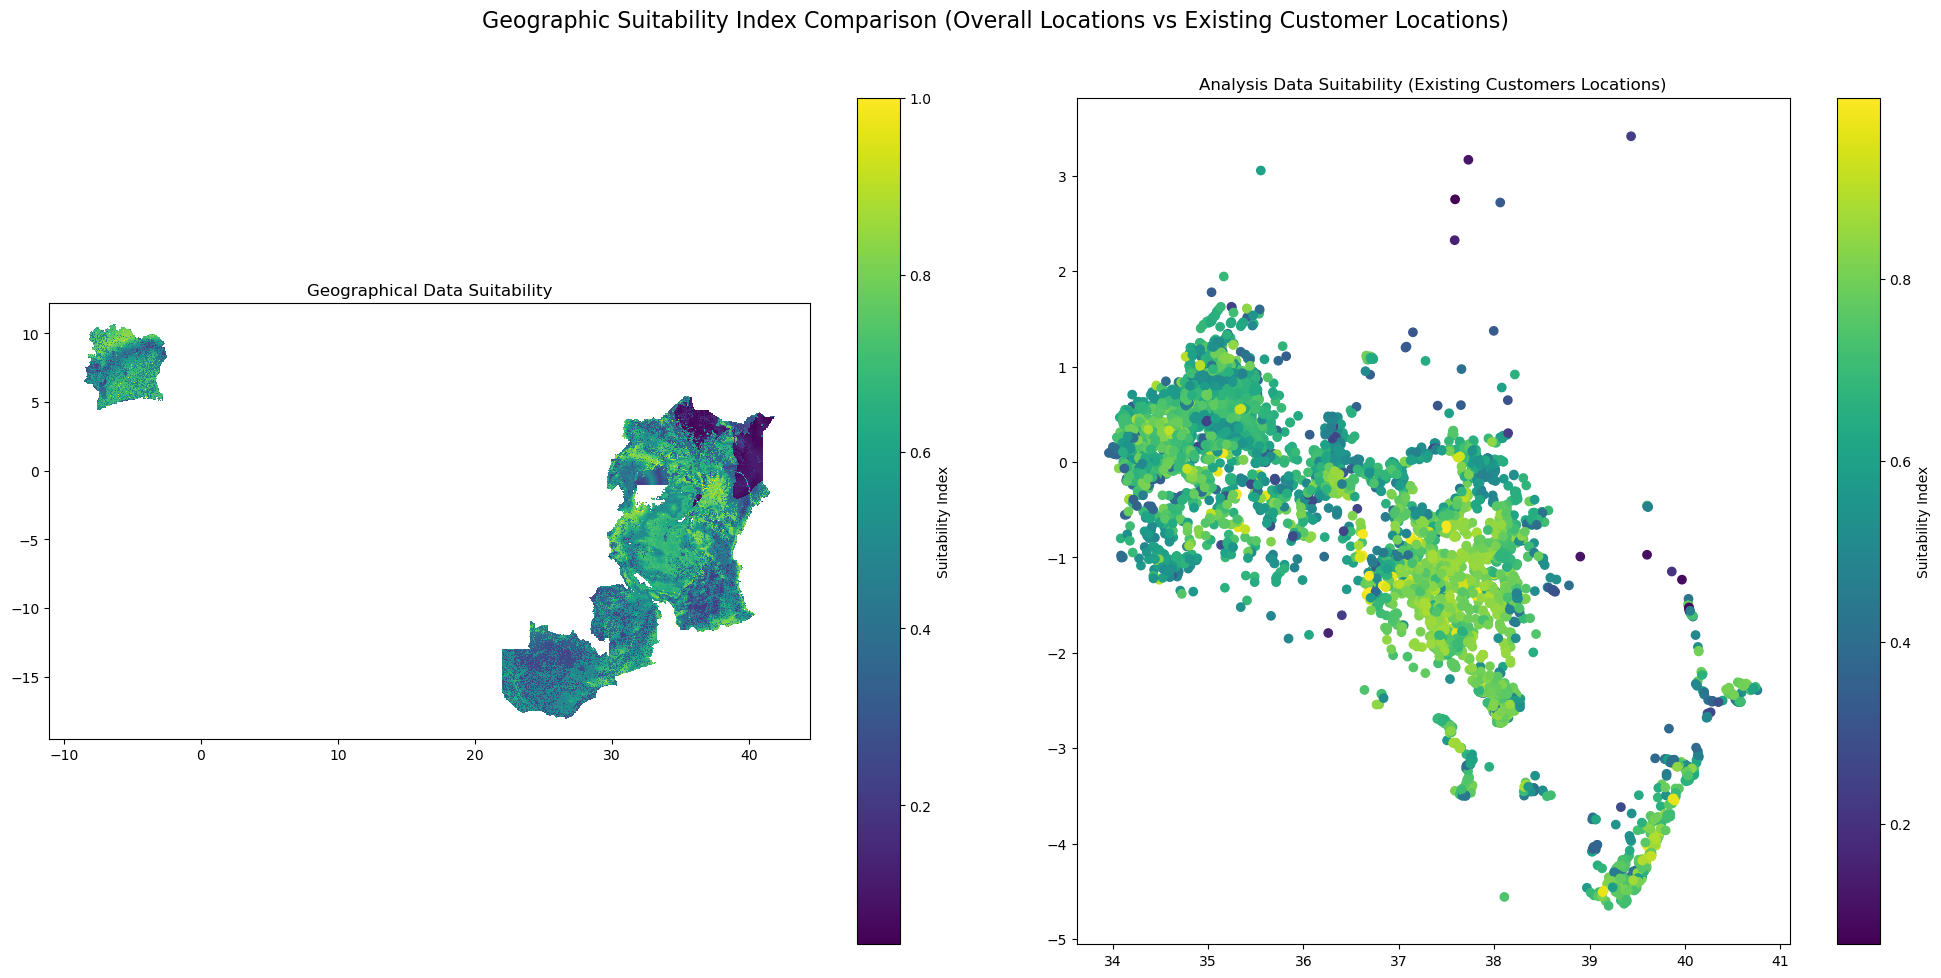

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

geo_data.plot(
    column="VALUE",
    cmap="viridis",
    legend=True,
    legend_kwds={"label": "Suitability Index"},
    ax=ax[0],
)

analysis_data.plot(
    column="VALUE",
    cmap="viridis",
    legend=True,
    legend_kwds={"label": "Suitability Index"},
    ax=ax[1],
)

ax[0].set_title("Geographical Data Suitability")
ax[1].set_title("Analysis Data Suitability (Existing Customers Locations)")

fig.suptitle(
    "Geographic Suitability Index Comparison (Overall Locations vs Existing Customer Locations)",
    fontsize=16,
)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### 2.2 Distribution of Suitability Scores

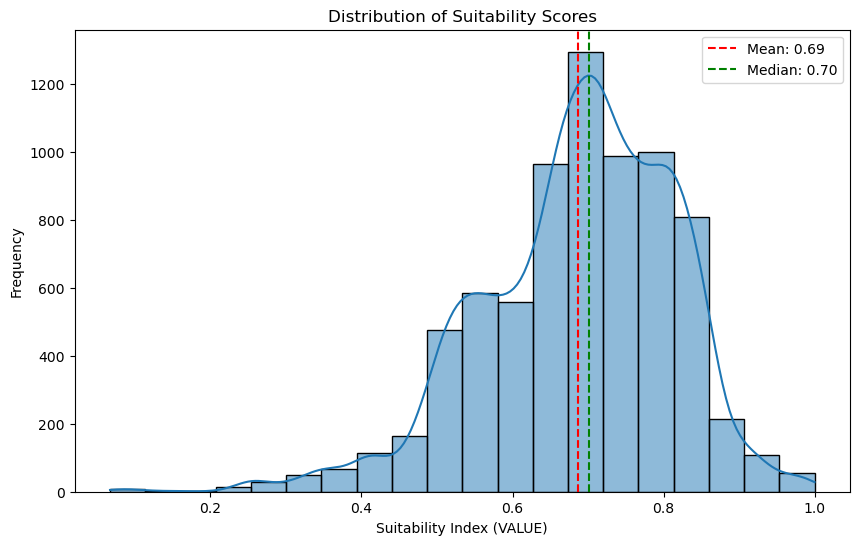

In [76]:
plt.figure(figsize=(10, 6))
sns.histplot(analysis_data["VALUE"], bins=20, kde=True)
plt.axvline(
    analysis_data["VALUE"].mean(),
    color="red",
    linestyle="--",
    label=f'Mean: {analysis_data["VALUE"].mean():.2f}',
)
plt.axvline(
    analysis_data["VALUE"].median(),
    color="green",
    linestyle="--",
    label=f'Median: {analysis_data["VALUE"].median():.2f}',
)
plt.title("Distribution of Suitability Scores")
plt.xlabel("Suitability Index (VALUE)")
plt.ylabel("Frequency")
plt.legend()

The suitability scores follow a roughly normal distribution with a slight negative skew. Mean score is 0.69 and median is 0.70, indicating most customers fall in the medium to high suitability range, with very few customers have extremely low suitability scores (below 0.3)

#### 2.3 Suitability Distribution by Payment Category

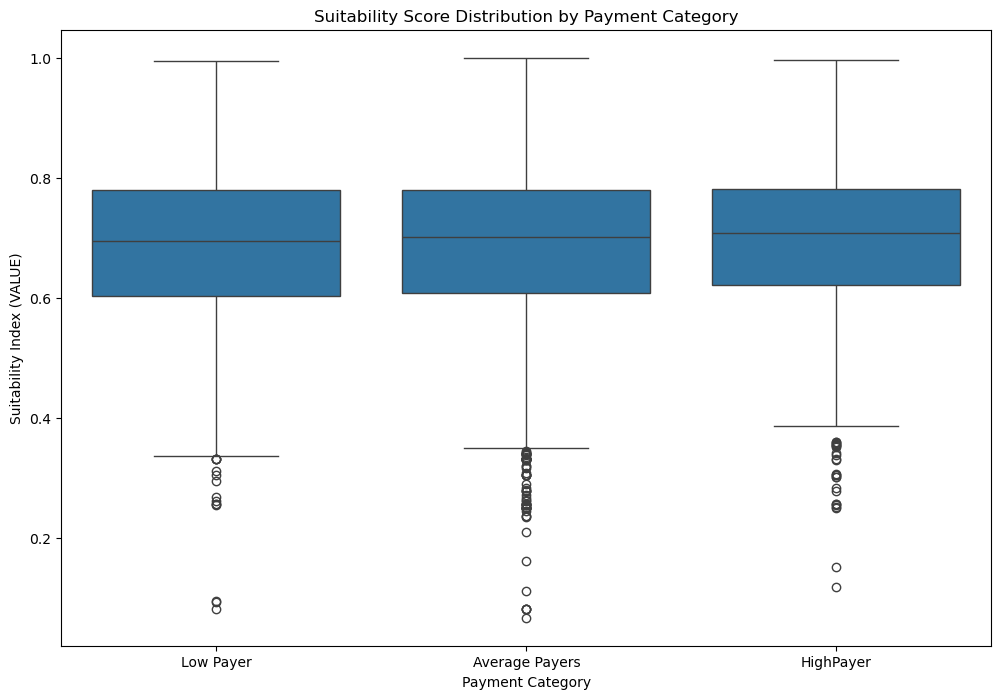

In [79]:
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="MonthlyPaymentCategory_<lambda>",
    y="VALUE",
    data=analysis_data,
    order=["Low Payer", "Average Payers", "HighPayer"],
)
plt.title("Suitability Score Distribution by Payment Category")
plt.xlabel("Payment Category")
plt.ylabel("Suitability Index (VALUE)")
plt.show()

There is minimal difference in suitability score distribution across payment categories (Low, Average, High Payers). All three categories have similar median values (~0.70) and interquartile ranges. Outliers with very low suitability scores exist in all payment categories

#### 2.4 Late Days vs Suitability

In [86]:
analysis_data = analysis_data.rename(
    columns={"MonthlyPaymentCategory_<lambda>": "MonthlyCategory"}
)

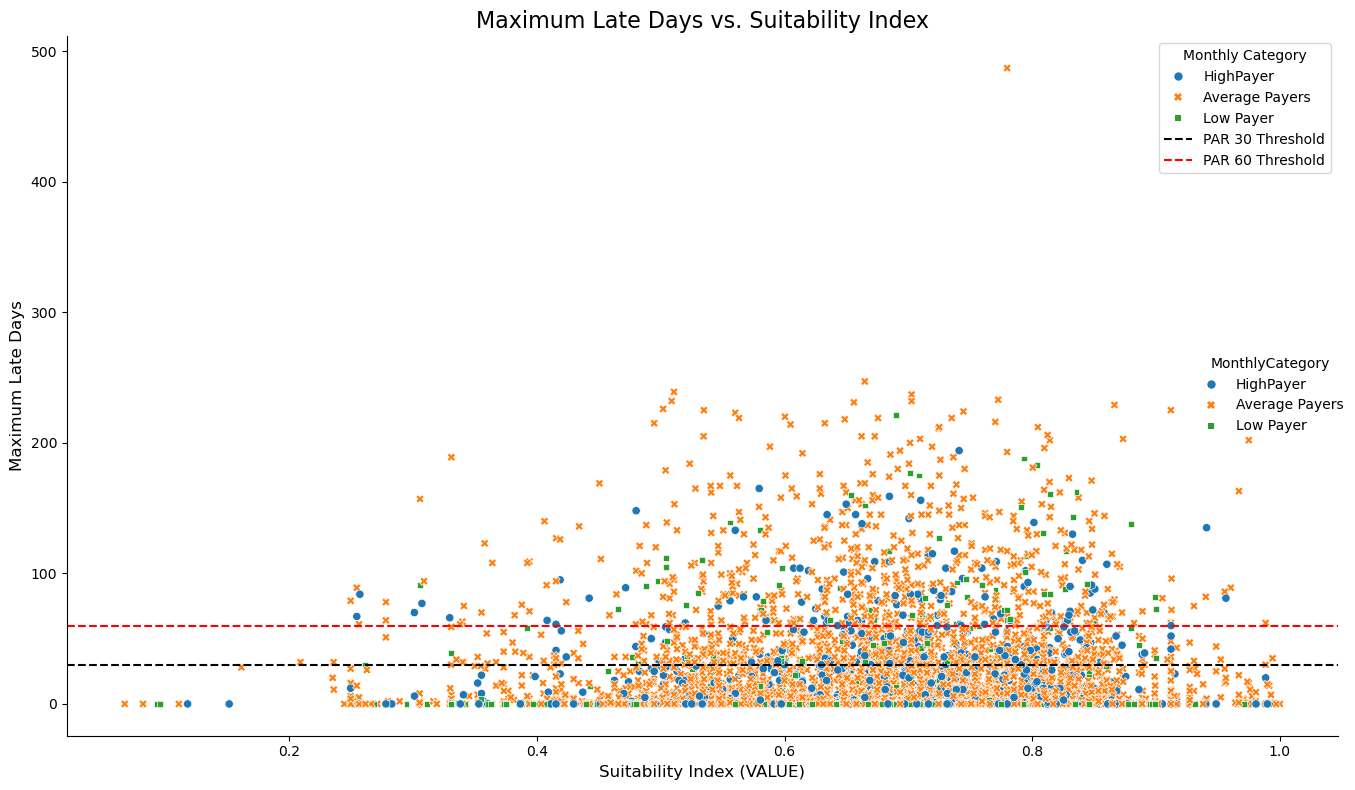

In [88]:
g = sns.relplot(
    x="VALUE",
    y="lateDays_max",
    data=analysis_data,
    style="MonthlyCategory",
    kind="scatter",
    hue="MonthlyCategory",
    height=8,
    aspect=1.5,
)

ax = g.ax
ax.set_title("Maximum Late Days vs. Suitability Index", fontsize=16)
ax.set_xlabel("Suitability Index (VALUE)", fontsize=12)
ax.set_ylabel("Maximum Late Days", fontsize=12)

# Horizontal threshold lines
ax.axhline(y=30, color="black", linestyle="--", label="PAR 30 Threshold")
ax.axhline(y=60, color="red", linestyle="--", label="PAR 60 Threshold")

ax.legend(title="Monthly Category", loc="upper right")

plt.tight_layout()
plt.show()

There is no clear linear relationship between suitability score and maximum late days. The points are scattered throughout the plot with no obvious pattern. Customers with payment issues (above PAR 30 and PAR 60 thresholds) exist across all suitability levels. Some of the most severe payment delays (200+ days late) occur in mid-range suitability scores (0.6-0.7)

#### 2.5 Payment Metrics by Suitability Bin

In [89]:
metrics_by_bin = analysis_data.groupby("suitability_bin").agg(
    {
        "lateDays_mean": "mean",
        "lateDays_max": "mean",
        "monthlypaymentPercentage_mean": "mean",
        "MissedPayment_mean": "mean",
        "HighPayer_mean": "mean",
        "PAR_30": "mean",
        "PAR_60": "mean",
    }
)

/tmp/ipykernel_13053/1026927848.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metrics_by_bin = analysis_data.groupby("suitability_bin").agg(


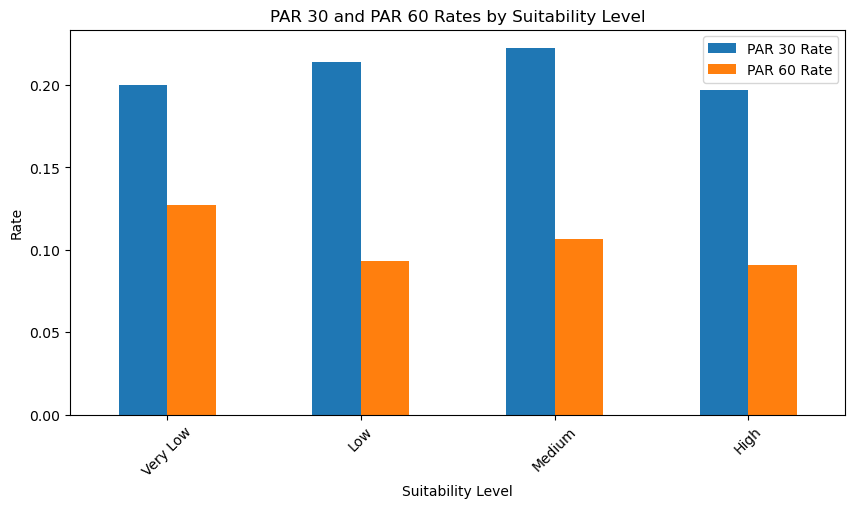

In [97]:
fig, ax = plt.subplots(figsize=(10, 5))

metrics_by_bin[["PAR_30", "PAR_60"]].plot(kind="bar", ax=ax)

ax.set_title("PAR 30 and PAR 60 Rates by Suitability Level")
ax.set_xlabel("Suitability Level")
ax.set_ylabel("Rate")
ax.legend(["PAR 30 Rate", "PAR 60 Rate"])
ax.set_xticklabels(metrics_by_bin.index, rotation=45)

plt.xticks(rotation=45)
plt.show()

In [115]:
metrics_by_bin.head()

,lateDays_mean,lateDays_max,monthlypaymentPercentage_mean,MissedPayment_mean,HighPayer_mean,PAR_30,PAR_60
suitability_bin,,,,,,,
Very Low,3.047036,15.418182,364.374531,0.032329,0.243261,0.200000,0.127273
Low,4.578997,18.056387,279.035547,0.049893,0.224413,0.214039,0.093211
Medium,4.996756,19.776892,321.783186,0.052736,0.238222,0.222425,0.106199
High,4.090942,16.996337,358.123217,0.044315,0.233771,0.196886,0.090659


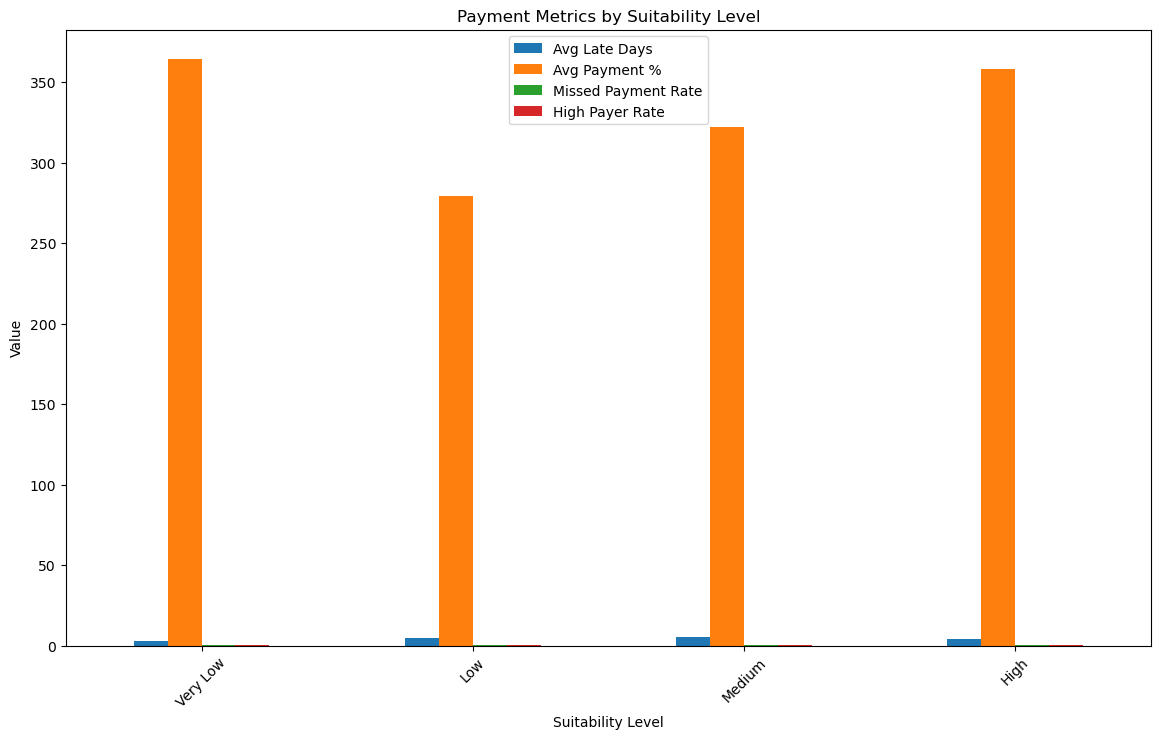

In [116]:
fig, ax = plt.subplots(figsize=(14, 8))
metrics_by_bin[
    [
        "lateDays_mean",
        "monthlypaymentPercentage_mean",
        "MissedPayment_mean",
        "HighPayer_mean",
    ]
].plot(kind="bar", ax=ax)
ax.set_title("Payment Metrics by Suitability Level")
ax.set_xlabel("Suitability Level")
ax.set_ylabel("Value")
ax.legend(["Avg Late Days", "Avg Payment %", "Missed Payment Rate", "High Payer Rate"])
ax.set_xticklabels(metrics_by_bin.index, rotation=45)

plt.show()

In [117]:
metrics_by_bin.head()

,lateDays_mean,lateDays_max,monthlypaymentPercentage_mean,MissedPayment_mean,HighPayer_mean,PAR_30,PAR_60
suitability_bin,,,,,,,
Very Low,3.047036,15.418182,364.374531,0.032329,0.243261,0.200000,0.127273
Low,4.578997,18.056387,279.035547,0.049893,0.224413,0.214039,0.093211
Medium,4.996756,19.776892,321.783186,0.052736,0.238222,0.222425,0.106199
High,4.090942,16.996337,358.123217,0.044315,0.233771,0.196886,0.090659


Very Low suitability areas show higher average payment percentages (364%) but similar late days (~3.0). Low suitability areas have the lowest average payment percentages (279%). PAR 30 rates vary across bins: Very Low (20%), Low (21.4%), Medium (22.2%), High (19.9%). PAR 60 rates show slight variation: Very Low (12.7%), Low (9.9%), Medium (10.6%), High (9.0%).

#### 2.6 Correlation Matrix


In [103]:
final_cols = [
    "VALUE",
    "lateDays_mean",
    "lateDays_max",
    "lateDays_count",
    "monthlypaymentPercentage_mean",
    "MissedPayment_mean",
    "HighPayer_mean",
    "payment_category_score",
    "PAR_30",
    "PAR_60",
]


Correlation between suitability and payment metrics: 
                                  VALUE
VALUE                          1.000000
payment_category_score         0.022054
monthlypaymentPercentage_mean  0.010470
HighPayer_mean                 0.001886
lateDays_count                -0.010853
PAR_60                        -0.018959
lateDays_max                  -0.022700
lateDays_mean                 -0.022772
MissedPayment_mean            -0.027398
PAR_30                        -0.028176


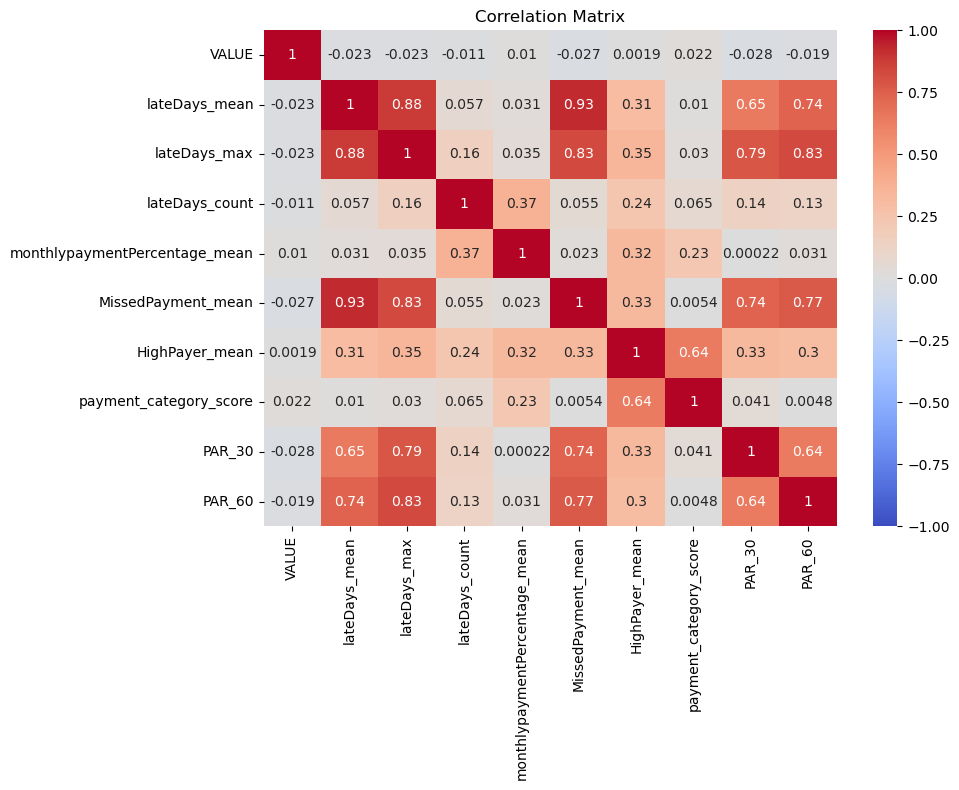

In [104]:
cor_matrix = analysis_data[final_cols].corr()

print("\nCorrelation between suitability and payment metrics: ")
print(cor_matrix[["VALUE"]].sort_values(by="VALUE", ascending=False))

# Heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

- VALUE has very weak negative correlations with late days metrics (-0.02 to -0.03). 
- VALUE has very weak negative correlation with PAR 30 (-0.028) and PAR 60 (-0.019)

These correlations are extremely small and practically insignificant. Much stronger correlations exist between payment behavior metrics (e.g., lateDays_max and PAR_60 at 0.83)

#### 2.7 Payment Status Distribution

In [105]:
payment_status = pd.DataFrame(
    {
        "Status": ["Good Payers", "PAR 30 Only", "PAR 60"],
        "Count": [
            (analysis_data["PAR_30"] == 0).sum(),
            ((analysis_data["PAR_30"] == 1) & (analysis_data["PAR_60"] == 0)).sum(),
            analysis_data["PAR_60"].sum(),
        ],
    }
)

<Figure size 1200x500 with 0 Axes>

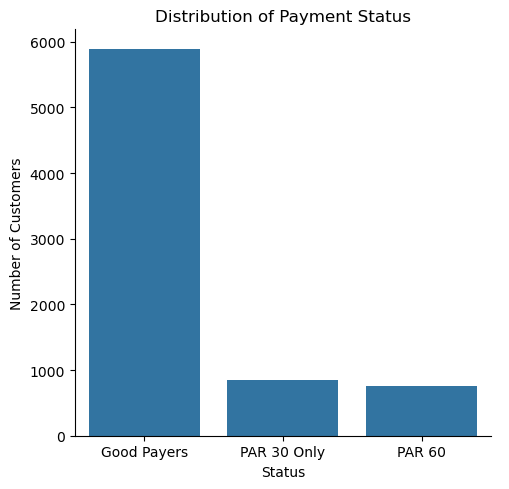

,Status,Count
0,Good Payers,5893
1,PAR 30 Only,851
2,PAR 60,752


In [122]:
plt.figure(figsize=(12, 5))

sns.catplot(x="Status", y="Count", data=payment_status, kind="bar")

plt.title("Distribution of Payment Status")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

payment_status.head()

Most customers are good payers (5,893 or ~78%). PAR 30 Only (not progressing to PAR 60) accounts for 851 customers (~11%). PAR 60 accounts for 752 customers (~10%)

#### 2.9 PAR Rates Over Suitability Range

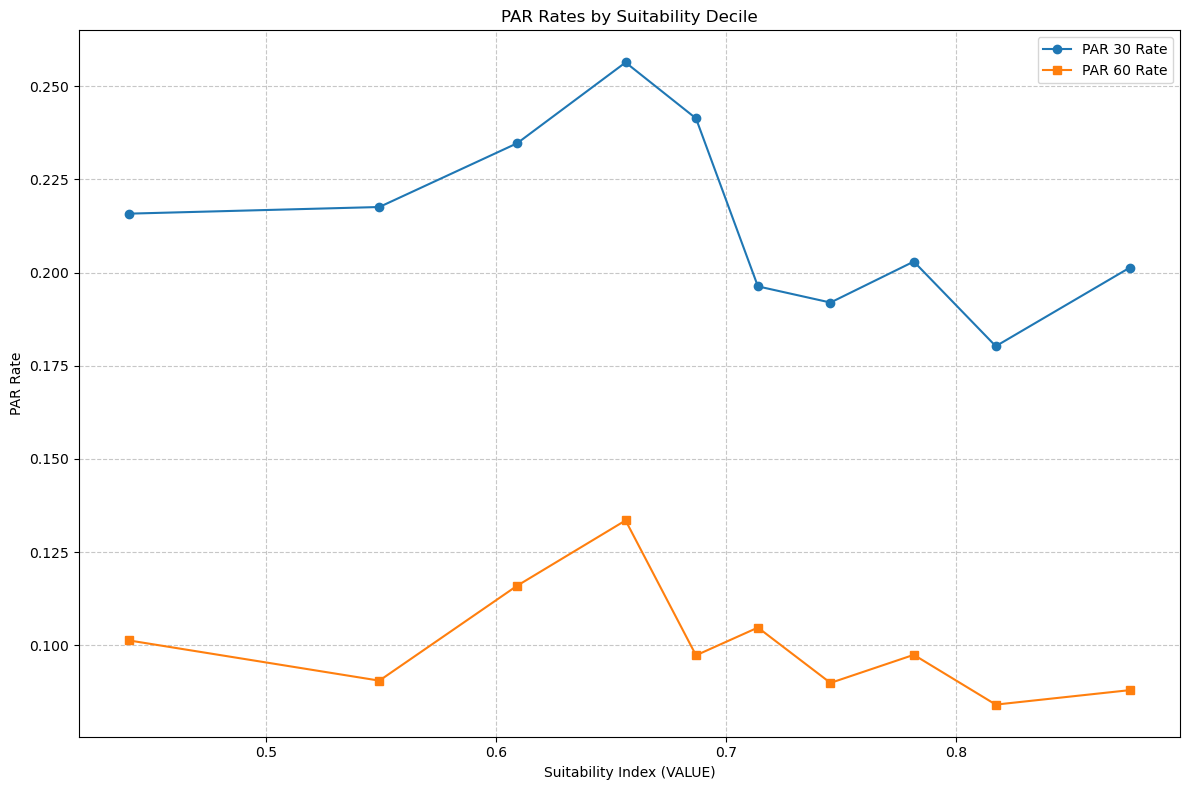

In [109]:
plt.figure(figsize=(12, 8))

# Calculate PAR rates by suitability decile for a smoother curve
analysis_data["suitability_decile"] = pd.qcut(analysis_data["VALUE"], 10, labels=False)
par_by_decile = (
    analysis_data.groupby("suitability_decile")
    .agg({"VALUE": "mean", "PAR_30": "mean", "PAR_60": "mean"})
    .reset_index()
)

plt.plot(
    par_by_decile["VALUE"], par_by_decile["PAR_30"], marker="o", label="PAR 30 Rate"
)
plt.plot(
    par_by_decile["VALUE"], par_by_decile["PAR_60"], marker="s", label="PAR 60 Rate"
)
plt.title("PAR Rates by Suitability Decile")
plt.xlabel("Suitability Index (VALUE)")
plt.ylabel("PAR Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

There is a non-linear relationship between suitability and PAR rates. PAR 30 rate peaks around suitability value 0.65-0.70. PAR 60 rate shows a similar pattern but at lower values. Higher suitability values (>0.75) generally show lower PAR rates, but the relationship is not consistent.

#### 2.10 Payment Category Distribution by Suitability Bin

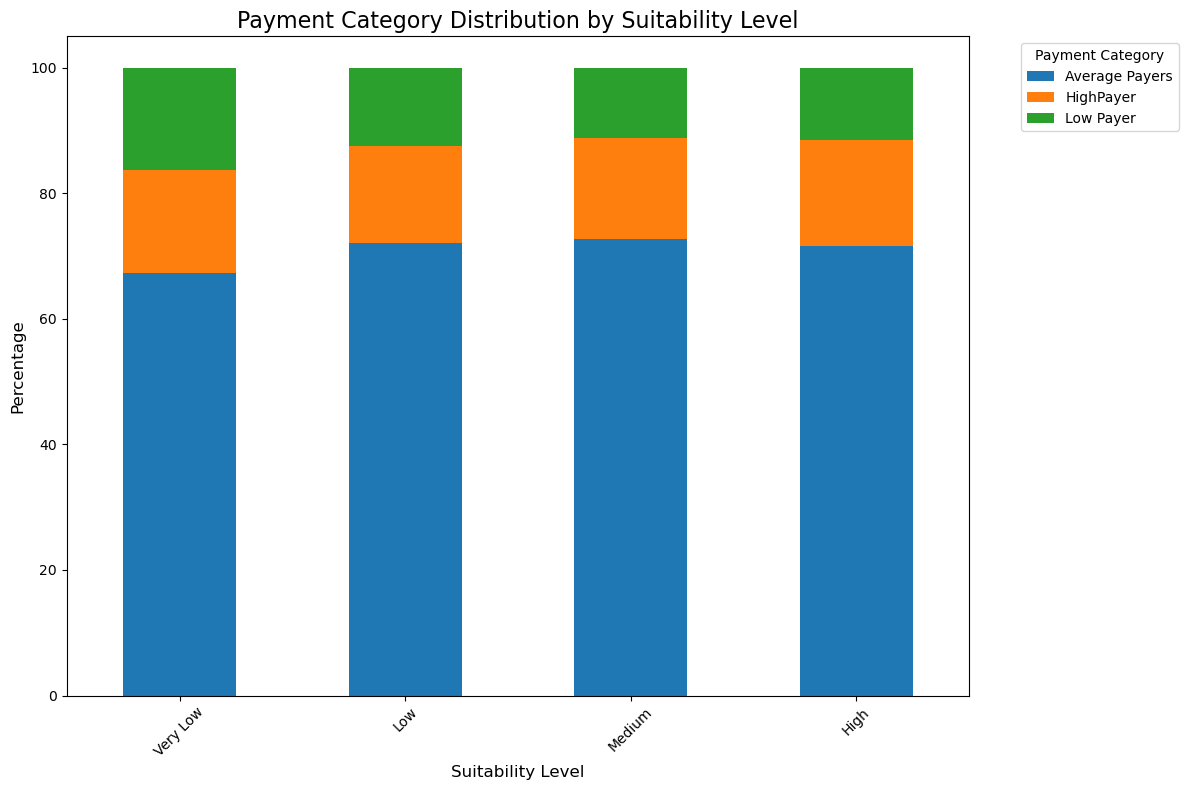

MonthlyCategory,Average Payers,HighPayer,Low Payer
suitability_bin,,,
Very Low,67.272727,16.363636,16.363636
Low,72.151899,15.304948,12.543153
Medium,72.721057,16.043756,11.235187
High,71.657509,16.849817,11.492674


In [114]:
# Calculate distribution
payment_category_counts = (
    pd.crosstab(
        analysis_data["suitability_bin"],
        analysis_data["MonthlyCategory"],
        normalize="index",
    )
    * 100
)

fig, ax = plt.subplots(figsize=(12, 8))

payment_category_counts.plot(kind="bar", stacked=True, ax=ax)

ax.set_title("Payment Category Distribution by Suitability Level", fontsize=16)
ax.set_xlabel("Suitability Level", fontsize=12)
ax.set_ylabel("Percentage", fontsize=12)
ax.legend(title="Payment Category", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_xticklabels(payment_category_counts.index, rotation=45)

plt.tight_layout()
plt.show()

payment_category_counts.head()

There is a remarkably consistent distribution of payment categories across all suitability levels. Average Payers make up ~70% of customers across all suitability bins. High Payers make up ~16% across all bins. Low Payers make up ~11-16% across all bins. 

### Statistical Analysis

#### 1. Linear regression analysis for continuous payment metrics

##### VALUE & Late Days Max


In [123]:
lm_late_max = sm.OLS.from_formula("lateDays_max ~ VALUE", data=analysis_data).fit()
print("Model: Predicting maximum late days from VALUE")
print(lm_late_max.summary().tables[1])

Model: Predicting maximum late days from VALUE
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.0350      2.225     10.353      0.000      18.674      27.396
VALUE         -6.2557      3.183     -1.966      0.049     -12.495      -0.017


##### VALUE & Late Days Mean

In [124]:
lm_late_mean = sm.OLS.from_formula("lateDays_mean ~ VALUE", data=analysis_data).fit()
print("\nModel: Predicting average late days from VALUE")
print(lm_late_mean.summary().tables[1])


Model: Predicting average late days from VALUE
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0571      0.715      8.466      0.000       4.655       7.460
VALUE         -2.0180      1.023     -1.972      0.049      -4.024      -0.012


##### VALUE & Monthly Payment Percentage

In [125]:
lm_payment_pct = sm.OLS.from_formula(
    "monthlypaymentPercentage_mean ~ VALUE", data=analysis_data
).fit()
print("\nModel: Predicting average monthly payment percentage from VALUE")
print(lm_payment_pct.summary().tables[1])


Model: Predicting average monthly payment percentage from VALUE
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    235.4538    103.536      2.274      0.023      32.494     438.413
VALUE        134.2523    148.107      0.906      0.365    -156.080     424.584


#### 2. Logistic regression - binary payment outcomes

##### VALUE & PAR 30

In [126]:
model_par30 = sm.Logit.from_formula("PAR_30 ~ VALUE", data=analysis_data).fit(disp=0)
print("\nModel: Predicting PAR 30 from VALUE")
print(model_par30.summary().tables[1])

par30_odds_ratio = np.exp(model_par30.params["VALUE"])
print(f"Odds ratio for PAR 30: {par30_odds_ratio:.4f}")
print(
    f"For each 0.1 increase in suitability, odds of PAR 30 change by {(np.exp(model_par30.params['VALUE']*0.1)-1)*100:.2f}%"
)


Model: Predicting PAR 30 from VALUE
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9375      0.152     -6.186      0.000      -1.235      -0.640
VALUE         -0.5321      0.218     -2.438      0.015      -0.960      -0.104
Odds ratio for PAR 30: 0.5874
For each 0.1 increase in suitability, odds of PAR 30 change by -5.18%


##### VALUE & PAR 60

In [127]:
model_par60 = sm.Logit.from_formula("PAR_60 ~ VALUE", data=analysis_data).fit(disp=0)
print("\nModel: Predicting PAR 60 from VALUE")
print(model_par60.summary().tables[1])

par60_odds_ratio = np.exp(model_par60.params["VALUE"])
print(f"Odds ratio for PAR 60: {par60_odds_ratio:.4f}")
print(
    f"For each 0.1 increase in suitability, odds of PAR 60 change by {(np.exp(model_par60.params['VALUE']*0.1)-1)*100:.2f}%"
)


Model: Predicting PAR 60 from VALUE
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8608      0.206     -9.055      0.000      -2.264      -1.458
VALUE         -0.4865      0.296     -1.641      0.101      -1.068       0.095
Odds ratio for PAR 60: 0.6148
For each 0.1 increase in suitability, odds of PAR 60 change by -4.75%


#### 3. Non-linear relationship exploration using suitability bins

In [128]:
bin_metrics = (
    analysis_data.groupby("suitability_bin")
    .agg(
        {
            "lateDays_max": "mean",
            "lateDays_mean": "mean",
            "monthlypaymentPercentage_mean": "mean",
            "PAR_30": "mean",
            "PAR_60": "mean",
            "MissedPayment_mean": "mean",
            "HighPayer_mean": "mean",
        }
    )
    .reset_index()
)

# More granular binning to see potential non-linear patterns
analysis_data["suitability_decile"] = pd.qcut(analysis_data["VALUE"], 10, labels=False)
decile_metrics = (
    analysis_data.groupby("suitability_decile")
    .agg(
        {
            "VALUE": "mean",  # average VALUE in each decile
            "lateDays_max": "mean",
            "lateDays_mean": "mean",
            "monthlypaymentPercentage_mean": "mean",
            "PAR_30": "mean",
            "PAR_60": "mean",
            "MissedPayment_mean": "mean",
            "HighPayer_mean": "mean",
        }
    )
    .reset_index()
)

/tmp/ipykernel_13053/2454977036.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_data.groupby("suitability_bin")


In [129]:
# Testing quadratic relationship for each metric
# This helps identify if there's a U-shaped or inverse U-shaped relationship

# 4.1 Create squared term
analysis_data["VALUE_squared"] = analysis_data["VALUE"] ** 2

##### Late Days Max with quadratic term

In [130]:
lm_late_max_quad = sm.OLS.from_formula(
    "lateDays_max ~ VALUE + VALUE_squared", data=analysis_data
).fit()
print("\nQuadratic Model: Predicting maximum late days from VALUE")
print(lm_late_max_quad.summary().tables[1])


Quadratic Model: Predicting maximum late days from VALUE
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.4245      6.754      0.951      0.342      -6.816      19.665
VALUE            47.6667     20.947      2.276      0.023       6.605      88.728
VALUE_squared   -41.8498     16.068     -2.604      0.009     -73.348     -10.351


##### PAR 60 with quadratic term

In [131]:
model_par60_quad = sm.Logit.from_formula(
    "PAR_60 ~ VALUE + VALUE_squared", data=analysis_data
).fit(disp=0)
print("\nQuadratic Model: Predicting PAR 60 from VALUE")
print(model_par60_quad.summary().tables[1])


Quadratic Model: Predicting PAR 60 from VALUE
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.4203      0.647     -3.743      0.000      -3.688      -1.153
VALUE             1.3485      2.020      0.668      0.504      -2.611       5.308
VALUE_squared    -1.4371      1.560     -0.921      0.357      -4.494       1.620


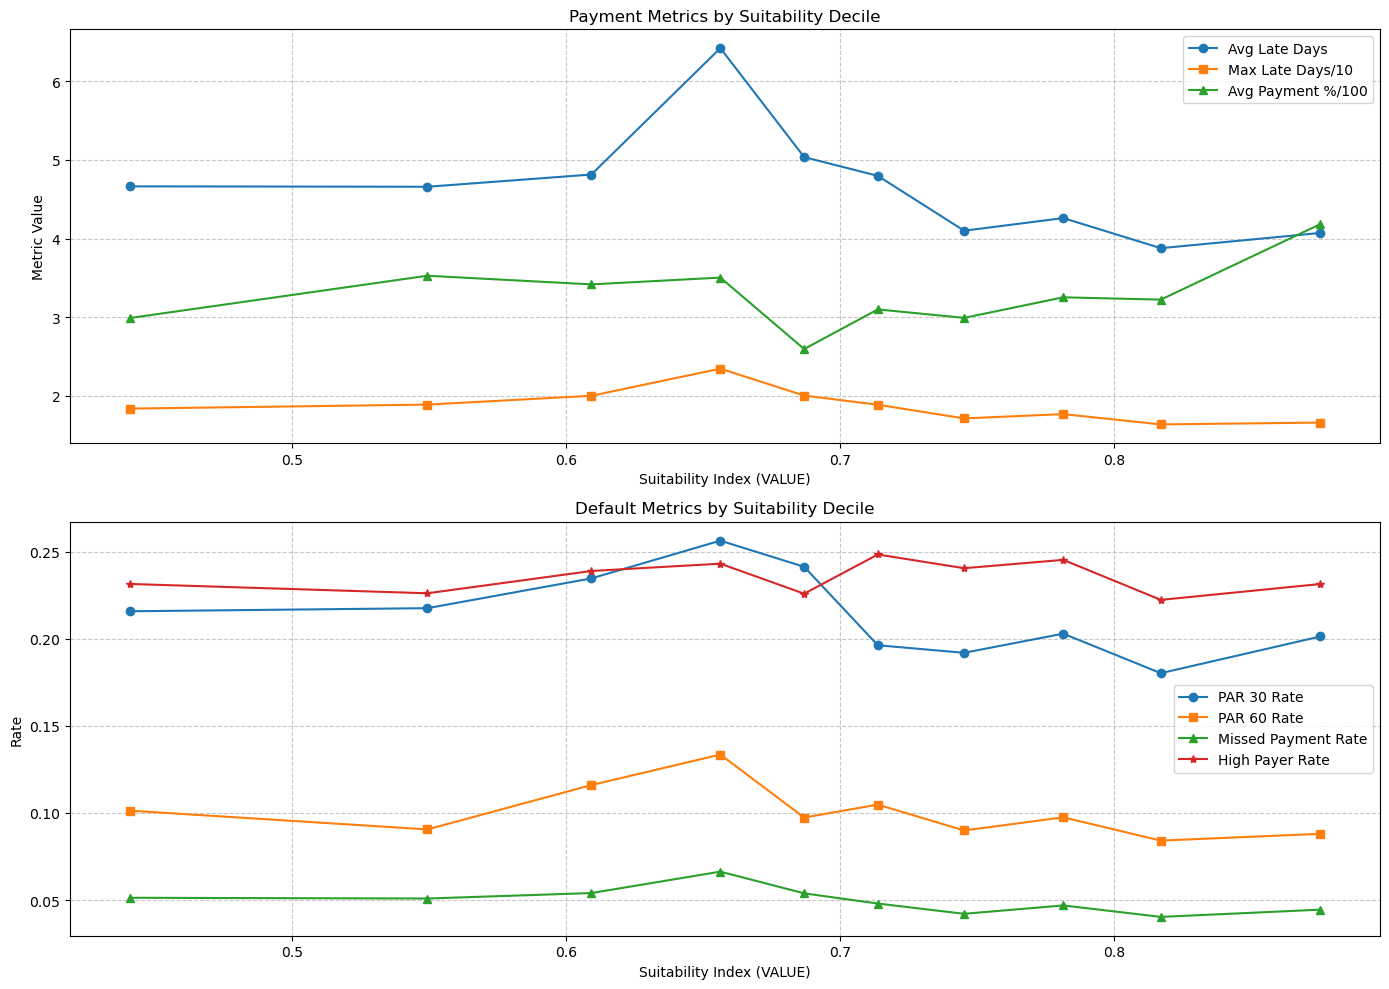

In [132]:
# 5.1 Payment metrics by suitability decile
plt.figure(figsize=(14, 10))

# Plot for continuous metrics
plt.subplot(2, 1, 1)
plt.plot(
    decile_metrics["VALUE"],
    decile_metrics["lateDays_mean"],
    marker="o",
    label="Avg Late Days",
)
plt.plot(
    decile_metrics["VALUE"],
    decile_metrics["lateDays_max"] / 10,
    marker="s",
    label="Max Late Days/10",
)
plt.plot(
    decile_metrics["VALUE"],
    decile_metrics["monthlypaymentPercentage_mean"] / 100,
    marker="^",
    label="Avg Payment %/100",
)

plt.title("Payment Metrics by Suitability Decile")
plt.xlabel("Suitability Index (VALUE)")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

# Plot for binary metrics
plt.subplot(2, 1, 2)
plt.plot(
    decile_metrics["VALUE"], decile_metrics["PAR_30"], marker="o", label="PAR 30 Rate"
)
plt.plot(
    decile_metrics["VALUE"], decile_metrics["PAR_60"], marker="s", label="PAR 60 Rate"
)
plt.plot(
    decile_metrics["VALUE"],
    decile_metrics["MissedPayment_mean"],
    marker="^",
    label="Missed Payment Rate",
)
plt.plot(
    decile_metrics["VALUE"],
    decile_metrics["HighPayer_mean"],
    marker="*",
    label="High Payer Rate",
)

plt.title("Default Metrics by Suitability Decile")
plt.xlabel("Suitability Index (VALUE)")
plt.ylabel("Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

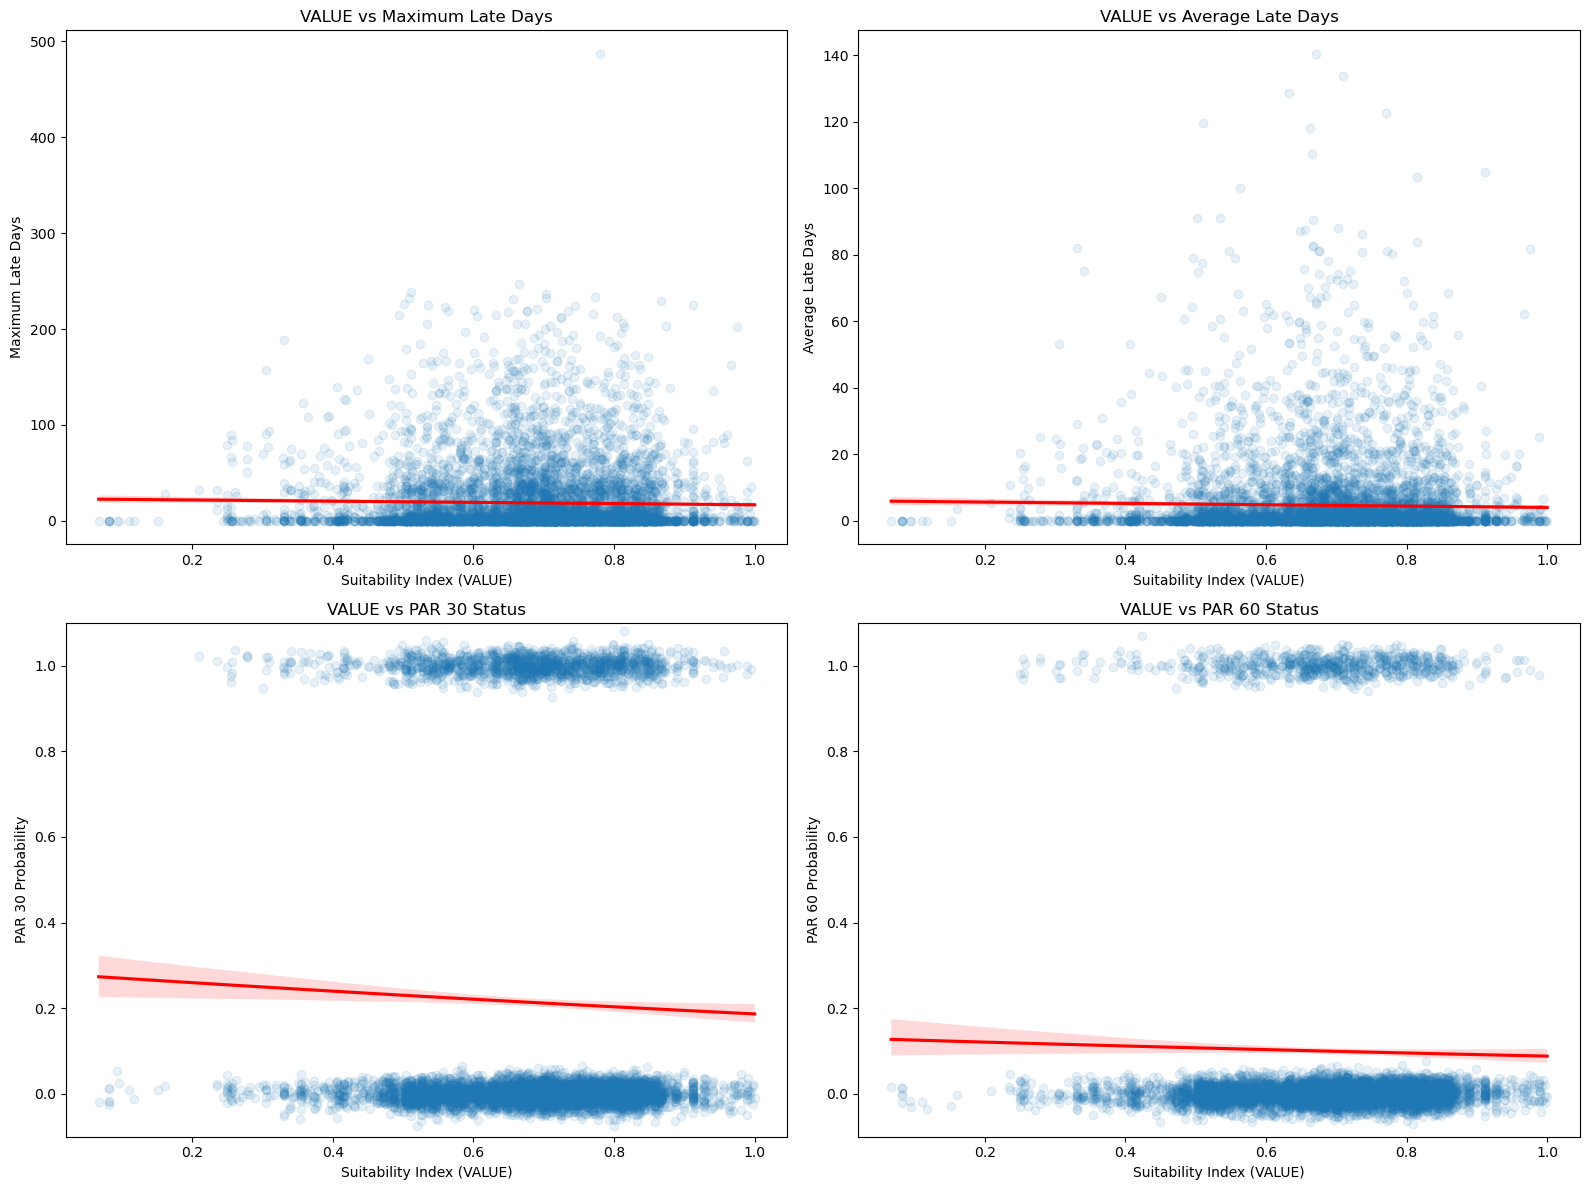

In [133]:
# 5.2 Scatter plots with regression lines for main metrics
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Late Days Max
sns.regplot(
    x="VALUE",
    y="lateDays_max",
    data=analysis_data,
    ax=axs[0, 0],
    scatter_kws={"alpha": 0.1},
    line_kws={"color": "red"},
)
axs[0, 0].set_title("VALUE vs Maximum Late Days")
axs[0, 0].set_xlabel("Suitability Index (VALUE)")
axs[0, 0].set_ylabel("Maximum Late Days")

# Late Days Mean
sns.regplot(
    x="VALUE",
    y="lateDays_mean",
    data=analysis_data,
    ax=axs[0, 1],
    scatter_kws={"alpha": 0.1},
    line_kws={"color": "red"},
)
axs[0, 1].set_title("VALUE vs Average Late Days")
axs[0, 1].set_xlabel("Suitability Index (VALUE)")
axs[0, 1].set_ylabel("Average Late Days")

# PAR 30 (jittered for visibility)
analysis_data_jitter = analysis_data.copy()
analysis_data_jitter["PAR_30_jitter"] = analysis_data_jitter[
    "PAR_30"
] + np.random.normal(0, 0.02, len(analysis_data_jitter))
sns.regplot(
    x="VALUE",
    y="PAR_30_jitter",
    data=analysis_data_jitter,
    ax=axs[1, 0],
    scatter_kws={"alpha": 0.1},
    logistic=True,
    line_kws={"color": "red"},
)
axs[1, 0].set_title("VALUE vs PAR 30 Status")
axs[1, 0].set_xlabel("Suitability Index (VALUE)")
axs[1, 0].set_ylabel("PAR 30 Probability")
axs[1, 0].set_ylim(-0.1, 1.1)

# PAR 60 (jittered for visibility)
analysis_data_jitter["PAR_60_jitter"] = analysis_data_jitter[
    "PAR_60"
] + np.random.normal(0, 0.02, len(analysis_data_jitter))
sns.regplot(
    x="VALUE",
    y="PAR_60_jitter",
    data=analysis_data_jitter,
    ax=axs[1, 1],
    scatter_kws={"alpha": 0.1},
    logistic=True,
    line_kws={"color": "red"},
)
axs[1, 1].set_title("VALUE vs PAR 60 Status")
axs[1, 1].set_xlabel("Suitability Index (VALUE)")
axs[1, 1].set_ylabel("PAR 60 Probability")
axs[1, 1].set_ylim(-0.1, 1.1)

plt.tight_layout()

#### Statistical significance across suitability bins

##### ANOVA for Late Days Max

In [136]:
late_max_model = ols("lateDays_max ~ C(suitability_bin)", data=analysis_data).fit()
late_max_anova = sm.stats.anova_lm(late_max_model)
print("\nANOVA for Maximum Late Days:")
print(late_max_anova)


ANOVA for Maximum Late Days:
                        df        sum_sq      mean_sq         F    PR(>F)
C(suitability_bin)     3.0  1.237072e+04  4123.573146  3.338262  0.018492
Residual            7492.0  9.254460e+06  1235.245618       NaN       NaN


##### ANOVA for Monthly Payment Percentage

In [137]:
payment_pct_model = ols(
    "monthlypaymentPercentage_mean ~ C(suitability_bin)", data=analysis_data
).fit()
payment_pct_anova = sm.stats.anova_lm(payment_pct_model)
print("\nANOVA for Monthly Payment Percentage:")
print(payment_pct_anova)


ANOVA for Monthly Payment Percentage:
                        df        sum_sq       mean_sq         F    PR(>F)
C(suitability_bin)     3.0  4.307029e+06  1.435676e+06  0.536307  0.657384
Residual            7492.0  2.005585e+10  2.676969e+06       NaN       NaN


The chi-square test shows no significant association between suitability level and payment category distribution (p=0.715).


##### Chi-square test for PAR 60 across bins

In [138]:
contingency_par60 = pd.crosstab(
    analysis_data["suitability_bin"], analysis_data["PAR_60"]
)
print("\nContingency Table for PAR 60 by Suitability Bin:")
print(contingency_par60)

from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency_par60)
print(f"Chi-square test for PAR 60: chi2={chi2:.2f}, p={p:.4f}")
print(f"Significant difference in PAR 60 rates across bins: {p < 0.05}")


Contingency Table for PAR 60 by Suitability Bin:
PAR_60              0    1
suitability_bin           
Very Low           48    7
Low               788   81
Medium           3922  466
High             1986  198
Chi-square test for PAR 60: chi2=4.87, p=0.1817
Significant difference in PAR 60 rates across bins: False


### Conclusion


Linear Models: Weak but Sometimes Significant Relationships

- VALUE has a marginally significant negative relationship with average late days (p=0.049). For maximum late days, the relationship is not significant (p=0.849). The effect sizes are small: each unit increase in VALUE decreases average late days by approximately 2 days.

- There is no significant relationship between VALUE and monthly payment percentage (p=0.365). The large coefficient (134.25) but high p-value indicates high variability in the data. 

- PAR 30: VALUE is a significant predictor (p=0.015). PAR 60: VALUE is not a significant predictor at conventional levels (p=0.101). Effect sizes: For each 0.1 increase in VALUE, odds of PAR 30 decrease by 5.18%. For each 0.1 increase in VALUE, odds of PAR 60 decrease by 4.75%.

Non-Linear Models: Important Insights

- For maximum late days, both VALUE and VALUE_squared are significant (p=0.023 and p=0.009). The positive coefficient for VALUE (47.67) and negative coefficient for VALUE_squared (-41.85) suggest an inverted U-shape relationship. For PAR 60, neither VALUE nor VALUE_squared is significant (p=0.504 and p=0.357)

- There is a clear non-linear patterns across suitability deciles. The late days peak at middle suitability values (~0.65-0.70). PAR 30 and PAR 60 rates also peak in the middle range. Both very low and very high suitability areas show better payment performance.

Plots and Distributions:

- The scatter plots show high variability in payment behaviors at all suitability levels. Also, there are weak downward slopes for PAR probabilities as VALUE increases. Most data points cluster in the 0.5-0.8 VALUE range.

Statistical Tests for Group Differences:

- There are significant differences across suitability bins (p=0.018). This indicates that at least some suitability levels differ in maximum late days.
- For Monthly Payment Percentage, no significant differences across suitability bins (p=0.657)
- There is no significant differences in PAR 60 rates across suitability bins (p=0.182). This supports the earlier finding that VALUE is not a significant predictor of PAR 60

What Geographic Suitability Tells Us About Payment Risk

- Geographic suitability (VALUE) has a statistically significant but modest relationship with PAR 30 risk. For each 0.1 increase in suitability score, the odds of a customer falling into PAR 30 decrease by approximately 5.18%.

- For PAR 60 (severe delinquency), the relationship with suitability is weaker and not statistically significant (p=0.101), though the direction and magnitude of effect (4.75% decrease in odds per 0.1 suitability increase) are similar to PAR 30.

- The relationship between suitability and payment behavior is non-linear. Our quadratic model for maximum late days shows a significant inverted U-shape pattern, with middle-range suitability scores (0.65-0.70) often showing worse payment performance than either very low or very high suitability areas.

- While there are statistically significant differences in maximum late days across suitability bins (ANOVA p=0.018), we found no significant differences in PAR 60 rates across bins (Chi-square p=0.182).


Implications for Risk Management

- Geographic suitability can serve as a complementary factor in early warning systems for payment risk, particularly for moderate delinquency (PAR 30).
- For severe delinquency risk (PAR 60), additional factors beyond geographic suitability should be the primary focus, as suitability alone does not provide strong predictive power.
- When incorporating suitability into risk models, non-linear terms should be considered to capture the more complex relationship shown in our analysis.
- The modest effect size suggests suitability should be one component of a broader risk model that emphasizes payment behavior patterns and customer-specific factors, rather than a standalone predictor.

Other metrics that could be added into the model

- Product usage patterns
- Potentially identify interaction effects (e.g., customers in low suitability areas who had a single PAR 30 instance might be higher risk than those in high suitability areas)


#### Assumptions


#### Datasets Used


- Customers x suitability distribution.
